In [1]:
from os import walk
import h5py
import numpy as np
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import math
from adabelief_tf import AdaBeliefOptimizer
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from os import walk
from skimage.transform import resize
from PIL import Image
import cv2
import functools
from sklearn.metrics import mean_squared_error

In [4]:
# IMAGE_WIDTH_SCALED = 200
# IMAGE_HEIGHT_SCALED = 200
NUMBER_OF_CHANNELS = 8


STARTS = []
model1_name = 'BERLIN.h5'
model2_name = 'CHICAGO.h5'
model3_name = 'ISTANBUL.h5'
model4_name = 'MELBOURNE.h5'
# model2_name = 'antwerp_all_data_normdoublekernels30.h5'

In [14]:
TIMESTEPS_X = 12
TIMESTEPS_Y = 6
X_Seq = TIMESTEPS_X * NUMBER_OF_CHANNELS
Y_Seq = TIMESTEPS_Y * NUMBER_OF_CHANNELS

#combine dimensions of 288 and 8 as in the CNN paper
def combine_dims(a, i=0, n=1):
  """
  Combines dimensions of numpy array `a`, 
  starting at index `i`,
  and combining `n` dimensions
  """
  s = list(a.shape)
  combined = functools.reduce(lambda x,y: x*y, s[i:i+n+1])
  return np.reshape(a, s[:i] + [combined] + s[i+n+1:])


# #concatenate volume channels into one:
# def scale_channels_and_size(data):
#     new_data = []

#     for img in data:
#         img = cv2.resize(img, (IMAGE_HEIGHT_SCALED, IMAGE_WIDTH_SCALED), Image.ANTIALIAS)
#         speed_avg = (img[:, :, 0] + img[:, :, 2] + img[:, :, 4] + img[:, :, 6]) / 4.0
#         volume_avg = (img[:, :, 1] + img[:, :, 3] + img[:, :, 5] + img[:, :, 7]) / 4.0
#         new_data.append(np.array([speed_avg, volume_avg]))
#     return np.array(new_data)

def data_preprocessing(data):
        
    x = []
    y = []
    
    #load the data and split it into 13:3 chunks
    data = np.moveaxis(data, -1, 1)
    data = combine_dims(data, 0) # combines dimension 0 and 1

    for i in range(10):
        start = np.random.randint(0, len(data)-(X_Seq+Y_Seq))
        x.append(np.asarray(data[start:start+X_Seq]))
        y.append(np.pad(np.asarray(data[start+X_Seq:start+(X_Seq+Y_Seq)]), pad_width=((0,0),(1,0),(6,6)), mode='constant'))
    
    #divide the data by 255 and take square root
    x = np.array(x)
    y = np.array(y)
    x = np.moveaxis(x, 1, -1)
    y = np.moveaxis(y, 1, -1)
    x = x / 255.
    y = y / 255.
    
    return x, y


def open_file(file):
    with h5py.File(file, 'r') as hf:
                #get the data
                a_group_key = list(hf.keys())[0]
                test = list(hf[a_group_key])

 

                # transform to appropriate numpy array 
                test = test[0:]
                test = np.stack(test, axis=0)
                return test



In [9]:
files = []
for (dirpath, dirnames, filenames) in walk('test_bangkok/'):
    files = filenames
    break

def get_losses(model_covid):
    losses_covid = []
#     losses_all = []
    
    for file in files:
        test = open_file('test_bangkok/' + file)
        x, y = data_preprocessing(test, COVID)
        predictions_covid = model_covid.predict(x)
#         predictions_all = model_all.predict(x)
        
        for i in range(len(predictions_covid)):
            loss_covid = ((predictions_covid[i] - y[i])**2).mean(axis=None)
            losses_covid.append(loss_covid)
            
#             loss_all = ((predictions_all[i] - y[i])**2).mean(axis=None)
#             losses_all.append(loss_all)
            
    return losses_covid

In [10]:
model_berlin = tf.keras.models.load_model(model1_name, compile=False)
losses_ber = get_losses(model_berlin, True)
np.savetxt("Berlin_model_bangkok_testdata.csv", losses_ber, delimiter=",")

In [11]:
model_istanbul = tf.keras.models.load_model(model3_name, compile=False)
losses_ist = get_losses(model_istanbul, True)
np.savetxt("Istanbul_model_bangkok_testdata.csv", losses_ist, delimiter=",")

In [12]:
model_chicago = tf.keras.models.load_model(model2_name, compile=False)
losses_chi = get_losses(model_chicago, True)
np.savetxt("Chicago_model_bangkok_testdata.csv", losses_chi, delimiter=",")

In [13]:
model_melbourne = tf.keras.models.load_model(model4_name, compile=False)
losses_mel = get_losses(model_melbourne, True)
np.savetxt("Melbourne_model_bangkok_testdata.csv", losses_mel, delimiter=",")

In [49]:
#AVERAGE
files = []
for (dirpath, dirnames, filenames) in walk('test_barcelona/'):
    files = filenames
    break

def get_losses_average(weights):
    losses = []
    for file in files:
        test = open_file('test_barcelona/' + file)
        xs = []
        ys = []
        pred = []
        
        
        #load the data and split it into 13:3 chunks
        data = np.moveaxis(test, -1, 1)
        #print(data.shape)
        for i in range(10):
            start = np.random.randint(0, len(data)-(12+6))
            xs.append(np.asarray(data[start:start+12]))
            ys.append(np.asarray(data[start+12:start+(12+6)]))
        for sequence in xs:
            x = sequence
            #print(x.shape)
            x = np.average(x, axis=0, weights=weights)
            x = np.expand_dims(x, axis=1)
            x = np.repeat(x, repeats=6, axis=1)
            # Convert the float value to uint8
            x = x.astype(np.uint8)
            # Set all speeds to 0 where there is no volume 
            x[:, :, :,  1] = x[:, :, :, 1] * (x[:, :, :,  0] > 0)
            x[:, :, :,  3] = x[:, :, :,  3] * (x[:, :, :,  2] > 0)
            x[:, :, :,  5] = x[:, :, :,  5] * (x[:, :, :,  4] > 0)
            x[:, :, :, 7] = x[:, :, :,  7] * (x[:, :, :,  6] > 0)
            x = np.moveaxis(x, 1, 0)
            pred.append(x)
            
        for i in range(len(pred)):
            loss = ((pred[i] - ys[i])**2).mean(axis=None)
            losses.append(loss)
        
    return losses
            
weights_flat = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 5, 6]
weights_steep = [1, 1, 1, 1, 1, 2, 2, 3, 3, 5, 7, 9]
naive_average_weights = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
loss_flat = get_losses_average(weights_flat)

In [52]:
loss_steep = get_losses_average(weights_steep)
loss_naive = get_losses_average(naive_average_weights)

In [53]:
np.savetxt("loss_flat_test_barcelona.csv", loss_flat, delimiter=",")
np.savetxt("loss_steep_test_barcelona.csv", loss_steep, delimiter=",")
np.savetxt("loss_naive_test_barcelona.csv", loss_naive, delimiter=",")

In [54]:
print(np.mean(loss_steep))
print(np.mean(loss_naive))
print(np.mean(loss_flat))

0.7259982846430667
0.8384297514518272
0.807226798759769


Visualise a prediction

In [25]:
#only need to change these 3
model = tf.keras.models.load_model(model_name, compile=False)
excel_row = 13
seq = 14

In [54]:
def data_preprocessing_image(data, seq):
    
    x = []
    y = []
    
    #load the data and split it into 13:3 chunks
    data = np.moveaxis(data, -1, 1)
    data = combine_dims(data, 0) # combines dimension 0 and 1

    for i in range(10):
        start = np.random.randint(0, len(data)-(X_Seq+Y_Seq))
        x.append(np.asarray(data[start:start+X_Seq]))
        y.append(np.pad(np.asarray(data[start+X_Seq:start+(X_Seq+Y_Seq)]), pad_width=((0,0),(1,0),(6,6)), mode='constant'))
    
    #divide the data by 255 and take square root
    x = np.array(x)
    y = np.array(y)
    x = np.moveaxis(x, 1, -1)
    y = np.moveaxis(y, 1, -1)
    x = x / 255.
    y = y / 255.
    
    return x, y

def get_image(row, seq):
    file = row // 18
    #seq = row % 18
    
    test = open_file('test_berlin/' + files[file])
    return data_preprocessing_image(test, seq)

    predictions = model_alldata.predict(x[-1:])

In [55]:
x, y = get_image(excel_row, seq)
predictions = model.predict(x)
print(predictions.shape)
print(x.shape)

(10, 496, 448, 48)
(10, 495, 436, 96)


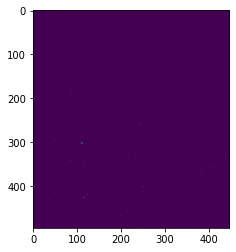

In [39]:
plt.imshow(predictions[1, :, :, 3])

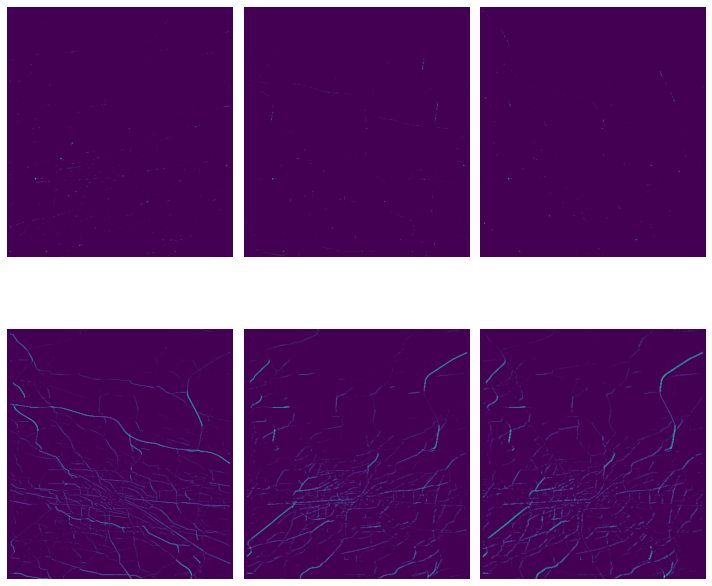

In [58]:
#prediction
f, axarr = plt.subplots(2,3, figsize=(10,10))
axarr[0,0].imshow(predictions[1, :, :, 0]*255.)
axarr[0,0].axis('off')
axarr[0,1].imshow(predictions[1, :, :, 2]*255.)
axarr[0,1].axis('off')
axarr[0,2].imshow(predictions[1, :, :, 4]*255.)
axarr[0,2].axis('off')
axarr[1,0].imshow(predictions[1, :, :, 1]*255.)
axarr[1,0].axis('off')
axarr[1,1].imshow(predictions[1, :, :, 3]*255.)
axarr[1,1].axis('off')
axarr[1,2].imshow(predictions[1, :, :, 5]*255.)
axarr[1,2].axis('off')
f.tight_layout()
plt.show()

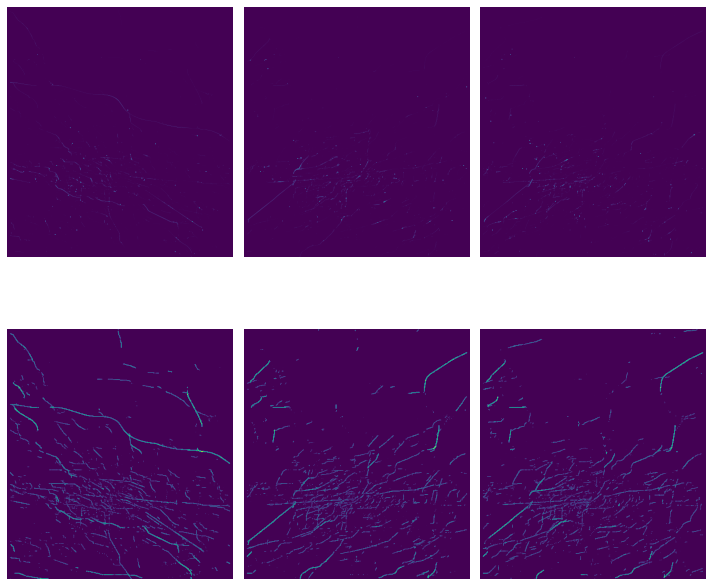

In [59]:
#ground truth
f, axarr = plt.subplots(2,3, figsize=(10,10))
axarr[0,0].imshow(y[1, :, :, 0]*255.)
axarr[0,0].axis('off')
axarr[0,1].imshow(y[1, :, :, 2]*255.)
axarr[0,1].axis('off')
axarr[0,2].imshow(y[1, :, :, 4]*255.)
axarr[0,2].axis('off')
axarr[1,0].imshow(y[1, :, :, 1]*255.)
axarr[1,0].axis('off')
axarr[1,1].imshow(y[1, :, :, 3]*255.)
axarr[1,1].axis('off')
axarr[1,2].imshow(y[1, :, :, 5]*255.)
axarr[1,2].axis('off')
f.tight_layout()
plt.show()